# **Introducción: Preparación Inicial para Actividades de Kubernetes**  

Antes de sumergirnos en las actividades prácticas relacionadas con Kubernetes y Ansible, es esencial preparar una máquina virtual base. Este paso inicial es clave para simplificar y optimizar el proceso de configuración de los entornos necesarios para las tareas, permitiéndonos ahorrar tiempo y esfuerzo en futuras etapas.  

---

## **Preparación Inicial: Crear una Máquina Base**  

### **¿Qué es la máquina base y por qué es importante?**  
La máquina base actúa como una plantilla preconfigurada que podremos clonar para crear múltiples máquinas virtuales rápidamente. Este enfoque nos garantiza un entorno uniforme y nos facilita la gestión de los recursos para actividades complejas.

---

### **Pasos para crear la máquina base**  

1. **Configuración inicial:**  
   - Crea una máquina virtual con las siguientes características:  
     - **Disco:** 10 GB.  
     - **Sistema operativo:** AlmaLinux 9.5 (versión minimal).  
     - **Particionado:** Usa la opción de autoparticionado para agilizar la instalación.  

2. **Guardado de la máquina base:**  
   - Una vez que completes la instalación:  
     - Guarda esta máquina virtual.  
     - Asígnale un nombre descriptivo, por ejemplo: `alma-9-base`.  

### **Ventajas de usar una máquina base:**  
- **Ahorro de tiempo:** Configuración inicial única, reutilizable en múltiples escenarios.  
- **Consistencia:** Todos los nodos creados desde esta base tendrán la misma configuración inicial.  
- **Flexibilidad:** Útil tanto para Kubernetes como para Ansible, adaptándose según las necesidades de cada tarea.  

---

## **Uso de la Máquina Base**  

### **1. Para configurar el clúster de Kubernetes:**  
- **Clonación:** Duplica la máquina base **tres veces**.  
- **Asignación de funciones:**  
  - Una máquina será el **nodo master**.  
  - Las otras dos serán los **nodos worker**.  

### **2. Para la actividad de Ansible:**  
- **Clonación:** Duplica la máquina base **cuatro veces**.  
- **Asignación de funciones:**  
  - Una máquina será el **nodo Ansible** (controlador).  
  - Otra máquina será el **nodo master**.  
  - Las restantes serán los **nodos worker**.  

---

# **Guía para Crear un Clúster Kubernetes con Kubeadm en AlmaLinux 9**

Esta guía detalla los pasos para configurar un clúster de Kubernetes en un entorno local utilizando `kubeadm`, con VirtualBox como plataforma de virtualización. Se incluye un nodo master y dos nodos worker. 

Fuentes usadas:
 - [How to Install Kubernetes on Rocky Linux 9 | AlmaLinux 9](https://www.linuxtechi.com/install-kubernetes-on-rockylinux-almalinux/#Step_1_Set_Hostname_and_Update_Hosts_file)
 - [How to install Kubernetes on Linux (AlmaLinux)](https://www.liquidweb.com/help-docs/install-kubernetes-on-linux-almalinux/)
 - [Cómo Instalar Cluster Kubernetes con kubeadm](https://blogvisionarios.com/articulos-data/como-instalar-cluster-kubernetes-kubeadm/#_Prerequisitos)
 - [Kubernetes: Bootstrap de Cluster con Kubeadm](https://blogvisionarios.com/articulos-data/kubernetes-bootstrap-cluster-kubeadm/)
 - [Kubernetes: Instalar cluster Kubernetes con kubeadm](https://blogvisionarios.com/articulos-data/kubernetes-instalar-cluster-kubernetes-con-kubeadm/)

---

## **1. Configuración Inicial del Laboratorio**

### **Especificaciones de las Máquinas Virtuales**
- **Nodo Master**:  
  - **RAM**: 2 GiB  
  - **CPU**: 2 vCPU  
  - **Disco**: 10 GiB (reservado dinámicamente)  
  - **NIC**: Red NAT (`192.168.1.6`)  
  - **SO**: AlmaLinux 9.4 Minimal  

- **Nodos Worker**:  
  - **RAM**: 1 GiB  
  - **CPU**: 1 vCPU  
  - **Disco**: 10 GiB (reservado dinámicamente)  
  - **NIC**: Red NAT (`192.168.1.7` y `192.168.1.8`)  
  - **SO**: AlmaLinux 9.4 Minimal  

---

## **2. Configuración de la Red**
Configuramos IP estáticas en cada máquina virtual utilizando `nmcli`. Estos pasos se realizan en **todas las máquinas**:  

### **Paso 1: Configuración Manual de IP Estática, DNS y Gateway**
Editamos o creamos el archivo de configuración de red:  
```bash
nmcli con mod enp0s3 ipv4.address XXX.XXX.X.X/24 ipv4.method manual
nmcli con mod enp0s3 ipv4.gateway 192.168.1.1
nmcli con mod enp0s3 ipv4.dns 212.166.211.3
nmcli con down enp0s3
nmcli con up enp0s3
```

---

### **Paso 2: Eliminar IPs Dinámicas**
En caso de que persistan direcciones asignadas por DHCP:  
```bash
sudo ip addr del 192.168.1.X/24 dev enp0s3
```

---

### **Paso 3: Reinicio de NetworkManager**
```bash
sudo systemctl restart NetworkManager
```

---

## **3. Configuración del Entorno Base**
Estos pasos se realizan en **todas las máquinas**:  

### **Paso 1: Configuración de Hostnames y Hosts**
En el nodo master:  
```bash
sudo hostnamectl set-hostname master
```
En los nodos worker:  
```bash
sudo hostnamectl set-hostname workerX # worker1 o worker2
```

Añadimos las entradas en `/etc/hosts`:  
```bash
cat <<EOF | sudo tee -a /etc/hosts
192.168.1.6 master
192.168.1.7 worker1
192.168.1.8 worker2
EOF
```

---

### **Paso 2: Deshabilitar el Intercambio**
```bash
sudo swapoff -a
sudo sed -i '/swap/d' /etc/fstab
```

---

### **Paso 3: Configurar SELinux y Firewall**
- Deshabilitamos SELinux:  
  ```bash
  sudo setenforce 0
  sudo sed -i 's/^SELINUX=enforcing/SELINUX=permissive/' /etc/selinux/config
  ```

- Configuramos el firewall:
  **En todos los nodos**
  Habilitamos el servicio para que inicie automáticamente al arrancar:
  ```bash
  sudo systemctl enable firewalld
  sudo systemctl start firewalld
  sudo systemctl status firewalld
  ```
  **Nodo Master:**  
  ```bash
  sudo firewall-cmd --permanent --add-port={6443,2379,2380,10250,10251,10252,10257,10259,179}/tcp
  sudo firewall-cmd --permanent --add-port=4789/udp
  sudo firewall-cmd --reload
  ```

  **Nodos Worker:**  
  ```bash
  sudo firewall-cmd --permanent --add-port={179,10250,30000-32767}/tcp
  sudo firewall-cmd --permanent --add-port=4789/udp
  sudo firewall-cmd --reload
  ```

---

### **Paso 4: Habilitar Módulos del Kernel**
```bash
cat <<EOF | sudo tee /etc/modules-load.d/k8s.conf
br_netfilter
overlay
EOF

sudo modprobe br_netfilter
sudo modprobe overlay

cat <<EOF | sudo tee /etc/sysctl.d/k8s.conf
net.bridge.bridge-nf-call-iptables  = 1
net.bridge.bridge-nf-call-ip6tables = 1
net.ipv4.ip_forward                 = 1
EOF

sudo sysctl --system
```

---

## **4. Instalación de Containerd**
Estos pasos se realizan en **todas las máquinas**:  
1. Añadimos el repositorio de Docker:  
   ```bash
   sudo dnf config-manager --add-repo https://download.docker.com/linux/centos/docker-ce.repo
   ```
2. Instalamos Containerd:  
   ```bash
   sudo dnf install -y containerd.io
   ```
3. Configuramos Containerd:  
   ```bash
   containerd config default | sudo tee /etc/containerd/config.toml > /dev/null 2>&1
   sudo sed -i 's/SystemdCgroup \= false/SystemdCgroup \= true/g' /etc/containerd/config.toml
   sudo systemctl restart containerd
   sudo systemctl enable containerd
   sudo systemctl status containerd
   ```

---

## **5. Instalación de Herramientas de Kubernetes**
Estos pasos se realizan en **todas las máquinas**:  
1. Añadimos el repositorio de Kubernetes:  
   ```bash
   cat <<EOF | sudo tee /etc/yum.repos.d/kubernetes.repo
   [kubernetes]
   name=Kubernetes
   baseurl=https://pkgs.k8s.io/core:/stable:/v1.29/rpm/
   enabled=1
   gpgcheck=1
   gpgkey=https://pkgs.k8s.io/core:/stable:/v1.29/rpm/repodata/repomd.xml.key
   exclude=kubelet kubeadm kubectl cri-tools kubernetes-cni
   EOF
   ```
2. Instalamos `kubeadm`, `kubelet` y `kubectl`:  
   ```bash
   sudo dnf install kubeadm kubelet kubectl --disableexcludes=kubernetes
   sudo systemctl start kubelet
   sudo systemctl status kubelet
   ```
   La opción -disableexcludes=kubernetes indica a DNF que no excluya paquetes relacionados con Kubernetes durante la instalación. Esto es importante porque algunos repositorios pueden tener exclusiones para paquetes específicos, y la selección de esta opción asegura que esas exclusiones son ignoradas.

---

## **6. Inicialización del Clúster**
1. En el nodo master:  
   ```bash
   sudo kubeadm init --pod-network-cidr=172.16.0.0/12
   ```

2. Configuramos acceso a `kubectl`:  
   ```bash
   mkdir -p $HOME/.kube
   sudo cp /etc/kubernetes/admin.conf $HOME/.kube/config
   sudo chown $(id -u):$(id -g) $HOME/.kube/config
   ```

3. Guarda el comando `kubeadm join`:
   ```bash
   sudo kubeadm token create --print-join-command > join
   ```

4. Copia el archivo `join` desde master a los nodos worker:
   ```bash
   ssh-keygen -t rsa
   ssh-copy-id root@workerX
   scp join root@workerX:~
   ```

5. Únete al clúster desde los nodos worker:
   ```bash
   sudo $(cat join)
   ```

---

## **7. Configuración de la Red (Calico)**
En el nodo master:  
```bash
curl -O https://docs.projectcalico.org/manifests/calico.yaml
vi calico.yaml
```
Ahora vamos a configurar Calico, que por defecto viene configurado contra la red 192.168.0.0/16, para que utilice la red que hemos comentado anteriormente (y sobre la que ya hemos iniciado nuestro cluster). Para ello buscaremos dentro del fichero calico.yaml descargado anteriormente el campo “CALICO_IPV4POOL_CIDR” y le asignaremos el valor de red donde queramos que se vayan presentando nuestros pods al levantarse, que quedará así:

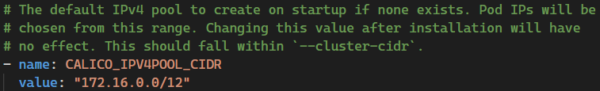

```bash
kubectl apply -f calico.yaml
```

---

## **8. Verificación del Clúster**
En el nodo master: 
Comprobamos que todos los nodos estén listos:  
```bash
kubectl get nodes
```
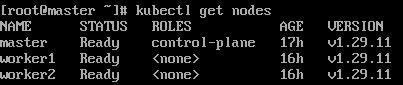
```
   NAME       STATUS   ROLES    AGE   VERSION  
   master     Ready    master   Xd    X.X.X  
   worker1    Ready    <none>   Xd    X.X.X  
   worker2    Ready    <none>   Xd    X.X.X  
```  

Deberías ver el nodo master y los dos workers con el estado `Ready`.

Comprobamos que todos los pods estén listos:
```bash
sudo kubectl get pods -n kube-system
```
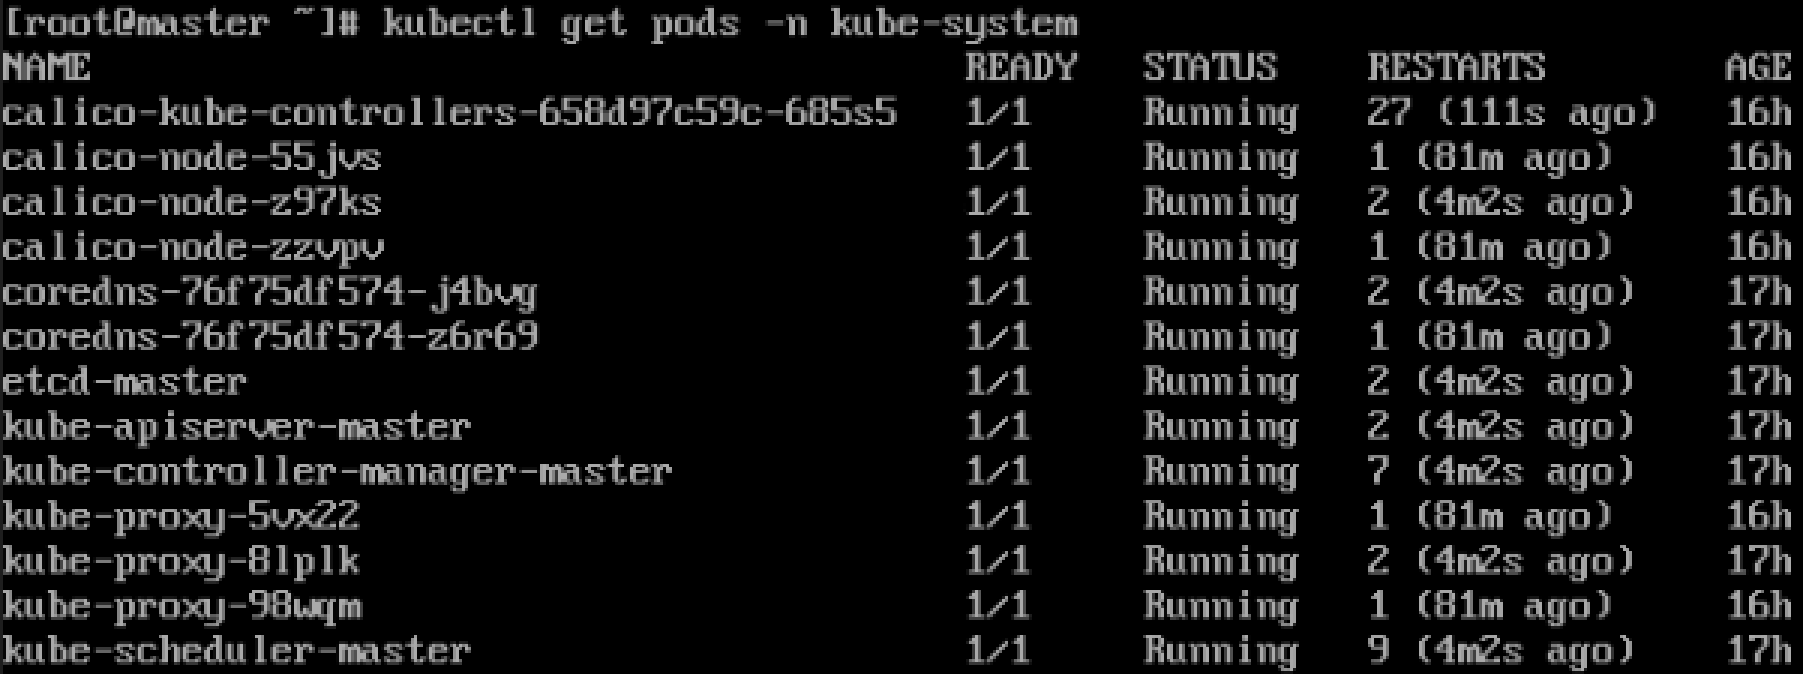

Deberías ver el nodo master y los dos workers con el estado `Running`.

---

## **9. Pruebas del Clúster**
En el nodo master: 
```bash
kubectl create deployment nginx --image=nginx
kubectl expose deployment nginx --port=80 --type=NodePort
kubectl get services
```
Accede al servicio en el puerto asignado. En este caso la prueba es bastante rudimentaria. En nuestro caso, al hacer el despliegue mediante esa orden (no hemos hecho uso de ficheros yaml, pero lo emplearemos más adelante), nuestro servicio se ha ido al worker2. Si hacemos una petición `curl` podemos ver la página de prueba de nginx "Welcome". A continuación se muestra el proceso:

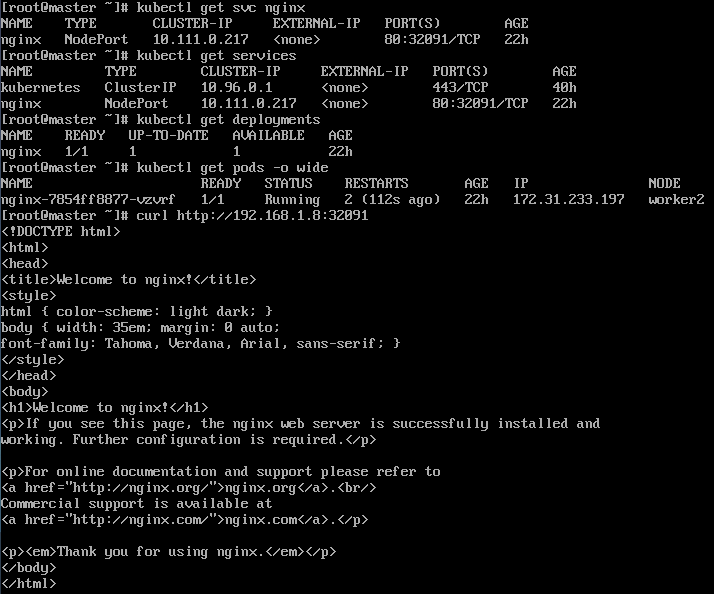

¡Hemos completado la configuración de nuestro clúster Kubernetes!

---

# **Guía para Crear un Clúster Kubernetes con Ansible (No usar Kubespray) en AlmaLinux 9**

Esta guía detalla los pasos para configurar un clúster de Kubernetes en un entorno local utilizando `Ansible`, con VirtualBox como plataforma de virtualización. Se incluye un nodo ansible, un nodo master y dos nodos worker. Hemos creado un repositorio de Github para programar todos los ansible playbook ya que como las maquinas virtuales tienen una versión minimal sin interfaz gráfica, para la edición constante de archivos es más rápido usar un repo y hacer git pull desde la maquina virtual con el repo clonado. Como para hacer pull se debe contar con un token para la autenticación, generé un token desde github, me lo guardé en un archivo de texto llamado pass, y cada vez que hacia cualquier cambio en los ficheros desde mi maquina host, hacia un push a la rama main, y en la maquina virtual hacia lo siguiente:
git pull https://brivaro:$(cat pass)@github.com/brivaro/ansible

Fuentes usadas:
 - [Automate Kubernetes Cluster Deployment with Ansible on CentOS Stream 8](https://www.hostafrica.com/blog/kubernetes/kubernetes-ansible-centos-stream-containerd/)  
 - [Cómo Instalar Kubernetes en Linux con Ansible](https://johnruizcampos.com/como-instalar-kubernetes-en-linux-con-ansible/)  
 - [Ansible + Kubernetes](https://spacelift.io/blog/ansible-kubernetes)  
 - [Kubernetes Setup Using Ansible Script](https://medium.com/@venkataramarao.n/kubernetes-setup-using-ansible-script-8dd6607745f6)  
 - [Install kubernetes on RockyLinux](https://www.linuxtechi.com/install-kubernetes-on-rockylinux-almalinux/)
 - [Repositorio Ansible Brian Valiente Rodenas](https://github.com/brivaro/ansible)  

---

## **1. Configuración inicial del laboratorio**

### **Especificaciones de las máquinas virtuales**

- **Nodo Ansible**:  
  - **RAM**: 2 GiB  
  - **CPU**: 2 vCPU  
  - **Disco**: 10 GiB (reservado dinámicamente)  
  - **NIC**: Red NAT (`192.168.1.5`)  
  - **SO**: AlmaLinux 9.4 Minimal  

- **Nodo Master**:  
  - **RAM**: 2 GiB  
  - **CPU**: 2 vCPU  
  - **Disco**: 10 GiB (reservado dinámicamente)  
  - **NIC**: Red NAT (`192.168.1.6`)  
  - **SO**: AlmaLinux 9.4 Minimal  

- **Nodos Worker**:  
  - **RAM**: 1 GiB  
  - **CPU**: 1 vCPU  
  - **Disco**: 10 GiB (reservado dinámicamente)  
  - **NIC**: Red NAT (`192.168.1.7` y `192.168.1.8`)  
  - **SO**: AlmaLinux 9.4 Minimal  

---

## **2. Instalación de Ansible en el nodo Ansible**

### **Paso 2.1: Actualizar el sistema**
Asegúrate de que el sistema esté actualizado:  
```bash
sudo dnf update -y
```

### **Paso 2.2: Instalar repositorios y Ansible**
1. Habilita el repositorio EPEL y luego instala Ansible:  
   ```bash
   sudo dnf install -y epel-release
   sudo dnf install -y ansible
   ```

2. Verifica la instalación:  
   ```bash
   ansible --version
   ```

---

## **3. Configuración inicial del nodo Ansible**

### **Paso 3: Configurar SSH sin contraseña**
1. Genera una clave SSH:  
   ```bash
   ssh-keygen -t rsa
   ```
   (Presiona Enter para usar la ubicación por defecto y deja la contraseña vacía).

2. Copia la clave pública a los nodos master y worker (antes de esto, `asegúrate que tienen la IP correspondiente, añádela en cada nodo como lo hicimos en la parte de kubeadm`):  
   ```bash
   ssh-copy-id root@192.168.1.6  # Master
   ssh-copy-id root@192.168.1.7  # Worker1
   ssh-copy-id root@192.168.1.8  # Worker2
   ```

3. Verifica que puedes conectarte sin contraseña:  
   ```bash
   ssh root@192.168.1.6
   ```

  `NOTA:` asegúrate que el nº de CPUs del master sea >= 2.

---

## **4. Configuración del inventario de Ansible**

### **Paso 4.1: Definir los nodos del clúster**
1. Crea un archivo `inventory.ini` para definir los nodos del clúster:  
   ```ini
   [master]
   master ansible_host=192.168.1.6

   [workers]
   worker1 ansible_host=192.168.1.7
   worker2 ansible_host=192.168.1.8

   [k8s:children]
   master
   workers

   [all:vars]
   ansible_user=root
   ansible_ssh_private_key_file=~/.ssh/id_rsa
   ```

2. Guarda este archivo en el directorio de trabajo o añádelo al final del archivo `/etc/ansible/hosts` para que sea accesible (`cat inventory.ini >> /etc/ansible/hosts`). De esta forma, definimos los nodos del clúster (cuando apliquemos los playbooks, tanto si usamos el archivo .ini o los hosts de ansible para indicar a qué nodos aplicar los cambios, será válido):

### **Paso 4.2: Validar conexión SSH con Ansible**
1. Prueba la conectividad entre el nodo Ansible y los nodos del clúster:  
   ```bash
   ansible all -m ping
   ```

   Si todo está configurado correctamente, deberías recibir un mensaje `SUCCESS` para cada nodo.

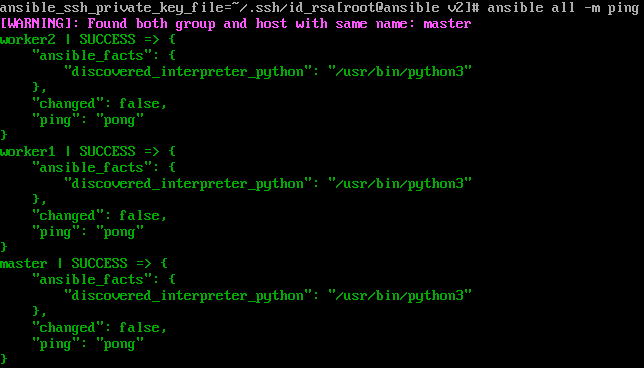

---

## **5. Creación y ejecución de los playbooks**

### **Paso 5.1: Crear playbooks para automatizar la instalación**
1. Los playbooks incluirán tareas como:  
   - Configuración inicial de nodos (deshabilitar swap, configurar SELinux, etc.).  
   - Instalación de Containerd.  
   - Instalación de Kubernetes (kubeadm, kubelet, kubectl).  
   - Inicialización del clúster en el nodo master.  
   - Configuración de red del clúster (Calico, por ejemplo).  
   - Unión de los nodos worker al clúster.
   - Configuración de Metallb, Metrics Server y despliegue de la web personalizada.

2. Estructura básica de un playbook (`ejemplo.yaml`):  
   ```yaml
   - hosts: all
     tasks:
       - name: Saludar
         command: echo "Hola a todos"
   ```

### **Paso 5.2: Ejecutar los playbooks**
1. Ejecuta los playbooks usando el inventario:  
   ```bash
   ansible-playbook -i inventory.ini ejemplo.yaml
   ```

2. Alternativamente, usa el archivo de hosts global:  
   ```bash
   ansible-playbook -i /etc/ansible/hosts ejemplo.yaml
   ```

#### **Configuración inicial**
```bash
   ansible-playbook -i /etc/ansible/hosts 1-config.yml
```

#### **Instalación de containerd y kubernetes**
```bash
   ansible-playbook -i /etc/ansible/hosts 2-installation.yml
```

#### **Inicialización del Cluster, unión de los workers y Calico**

```bash
   ansible-playbook -i /etc/ansible/hosts 3-inicluster.yml
   ansible-playbook -i /etc/ansible/hosts 4-calico.yml
```
`NOTA`: Aunque al hacer la tarea "Aplicar la configuración de Calico" salga en rojo un WARNING, igualmente calico se aplica de forma correcta (kubectl apply...).

Comprobamos que todos los pods estén listos:
```bash
sudo kubectl get pods -n kube-system
```
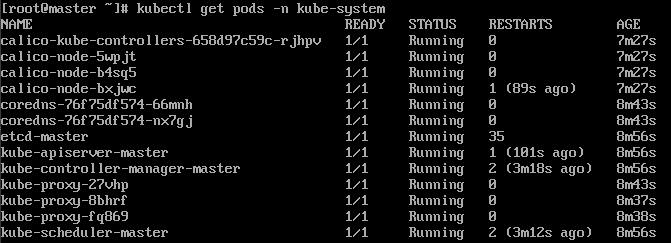

Deberías ver el nodo master y los dos workers con el estado `Running`.

¡Hemos completado la configuración de nuestro clúster Kubernetes como ya teniamos antes!

---

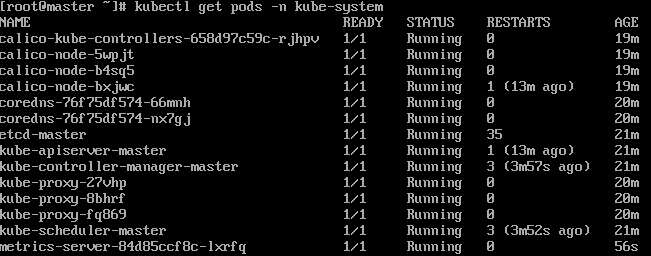

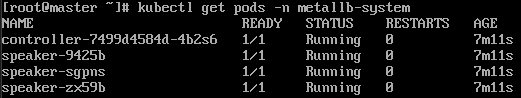

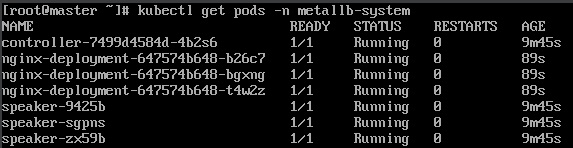

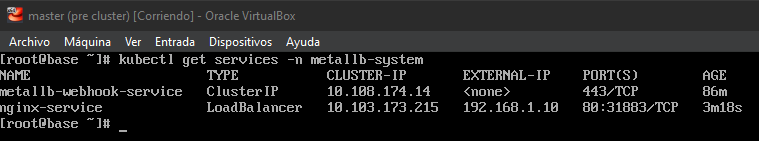

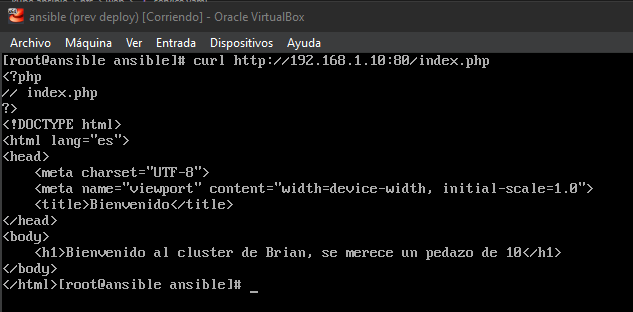

METRICSERVER
- https://computingforgeeks.com/fix-error-metrics-api-not-available-in-kubernetes/
- https://gist.github.com/NileshGule/8f772cf04ea6ae9c76d3f3e9186165c2
- https://github.com/kubernetes-sigs/metrics-server/issues/1282#issuecomment-2058481266 (con este lo resolví, la clave era nodeName)

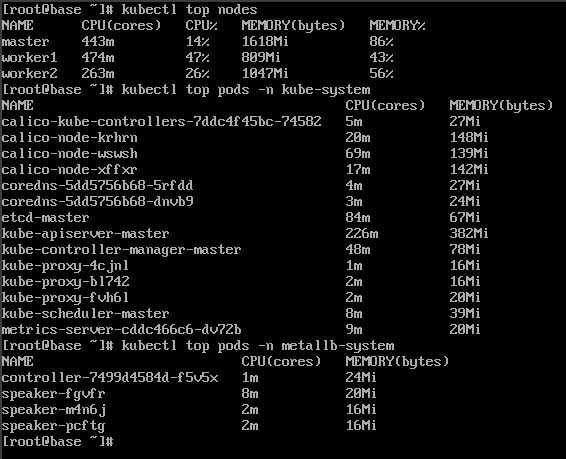

kubectl get hpa -n metallb-system
(ahora ya conocemos el porcentaje de uso que tenemos)

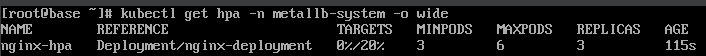


Se replican los recursos debido al HPA

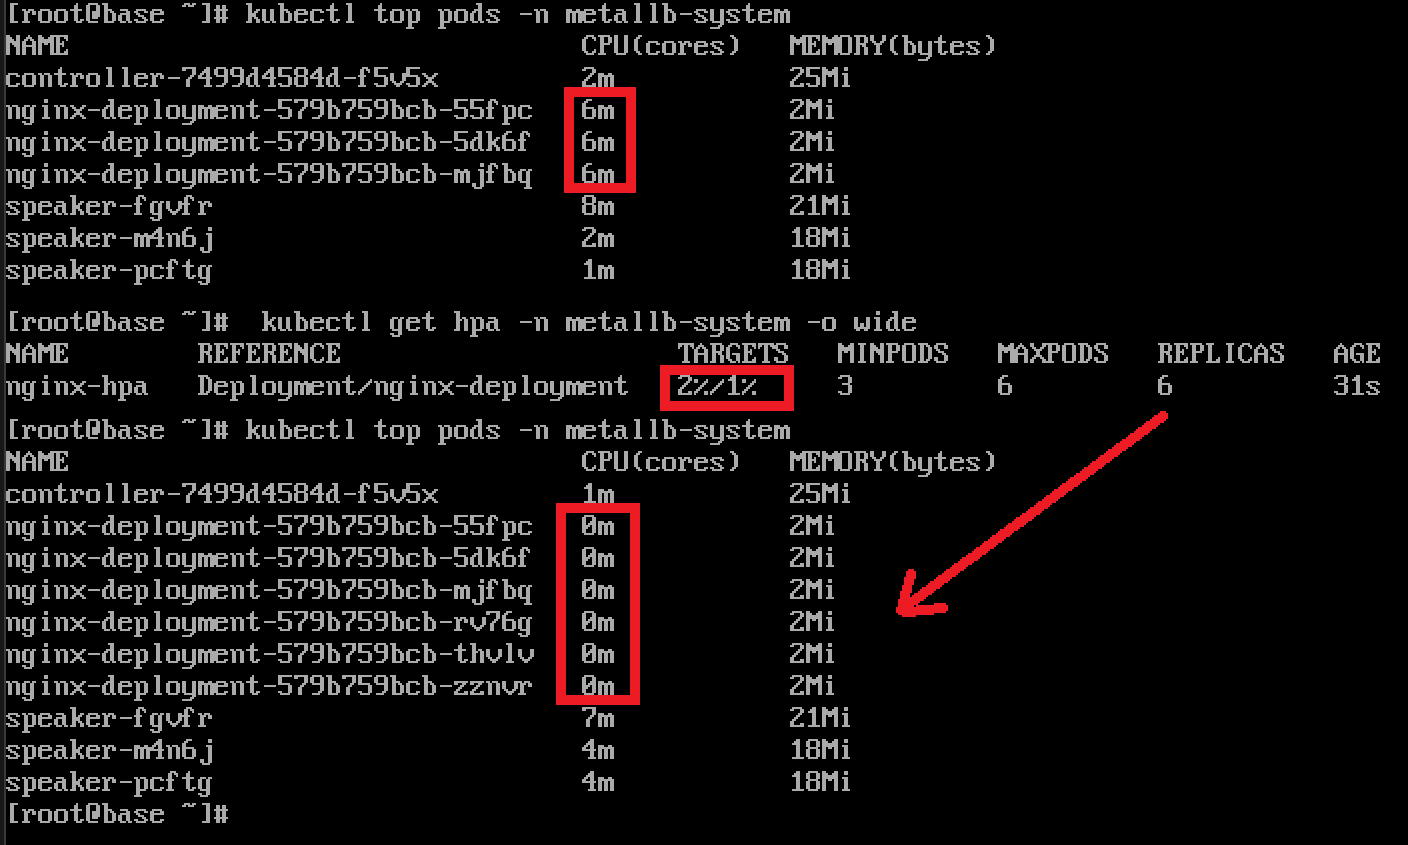

---
---
# **APÉNDICES** 
---
---

# **Gestión del clúster Kubernetes con kubectl**  

La herramienta estándar para interactuar con cualquier clúster Kubernetes, ya sea en la nube o local, es **kubectl**. Esta CLI (Interfaz de Línea de Comandos) permite gestionar y monitorizar los recursos del clúster de forma sencilla y potente.  

---

#### **Comandos básicos de kubectl**  

1. **Verificar el estado de los nodos**  
   - Comando:  
     ```bash
     kubectl get nodes -o wide
     ```  
   - Explicación:  
     Este comando muestra información detallada sobre los nodos del clúster, como su estado, roles (master o worker), versión de Kubernetes, dirección IP y otros detalles relevantes.  
   - Resultado esperado:  
     ```  
     NAME       STATUS   ROLES    AGE   VERSION  
     master     Ready    master   Xd    X.X.X  
     worker1    Ready    <none>   Xd    X.X.X  
     worker2    Ready    <none>   Xd    X.X.X  
     ```  

2. **Listar los pods**  
   - Comando:  
     ```bash
     kubectl get pods -o wide
     ```  
   - Explicación:  
     Muestra todos los pods desplegados en el clúster, indicando su estado (Running, Pending, Failed), el nodo donde se ejecutan, el tiempo de ejecución y otra información adicional.  
   - Resultado esperado:  
     ```  
     NAME            READY   STATUS    RESTARTS   AGE   NODE  
     app-pod-12345   1/1     Running   0          2d    worker1  
     db-pod-67890    1/1     Running   0          5h    worker2  
     ```  

3. **Listar otros recursos del clúster**  
   - **Servicios**:  
     ```bash
     kubectl get services
     ```  
     Explicación: Muestra los servicios activos, sus IP, puertos expuestos y tipos (ClusterIP, NodePort, LoadBalancer).  
   - **Deployments**:  
     ```bash
     kubectl get deployments
     ```  
     Explicación: Enumera los despliegues del clúster, incluyendo información sobre las réplicas deseadas y disponibles.  

4. **Listar recursos en un namespace específico**  
   - Comando:  
     ```bash
     kubectl get nodes -n kube-system
     ```  
   - Explicación:  
     Muestra los nodos o cualquier otro recurso dentro del namespace `kube-system`, el cual es reservado por Kubernetes para gestionar componentes internos como el controlador del clúster, el plano de control (control-plane), CoreDNS, entre otros.  

     Por ejemplo:  
     ```bash
     kubectl get pods -n kube-system
     ```  
     Resultado esperado:  
     ```  
     NAME                                       READY   STATUS    RESTARTS   AGE  
     coredns-abc123                             1/1     Running   0          7d  
     kube-apiserver-master                      1/1     Running   0          7d  
     kube-controller-manager-master             1/1     Running   0          7d  
     ```  

---

#### **Comandos adicionales útiles**  

1. **Describir un recurso**  
   - Comando:  
     ```bash
     kubectl describe <tipo-recurso> <nombre-recurso>
     ```  
   - Explicación:  
     Proporciona detalles extensos sobre el recurso especificado, como eventos recientes, configuraciones y estado actual. Por ejemplo:  
     ```bash
     kubectl describe pod app-pod-12345
     ```  

2. **Eliminar un recurso**  
   - Comando:  
     ```bash
     kubectl delete <tipo-recurso> <nombre-recurso>
     ```  
   - Ejemplo:  
     ```bash
     kubectl delete pod app-pod-12345
     ```  
     Esto eliminará el pod especificado del clúster.  

3. **Obtener registros (logs) de un pod**  
   - Comando:  
     ```bash
     kubectl logs <nombre-pod>
     ```  
   - Explicación:  
     Muestra los registros generados por el contenedor dentro de un pod. Muy útil para depuración.  

4. **Ejecutar un comando dentro de un pod**  
   - Comando:  
     ```bash
     kubectl exec -it <nombre-pod> -- <comando>
     ```  
   - Ejemplo:  
     ```bash
     kubectl exec -it app-pod-12345 -- bash
     ```  
     Esto abre un terminal interactivo dentro del pod.  

5. **Eliminar el cluster creado con init**  
   - Comando:  
     ```bash
     kubeadn reset
     ```  

---

#### **Despliegue de recursos con archivos YAML**  

1. **Aplicar un archivo YAML**  
   - Comando:  
     ```bash
     kubectl apply -f <archivo.yaml>
     ```  
   - Explicación:  
     Aplica la configuración definida en el archivo YAML para crear, actualizar o eliminar recursos en el clúster.  

2. **Verificar los recursos creados**  
   - Comando:  
     ```bash
     kubectl get <tipo-recurso>
     ```  
   - Ejemplo:  
     ```bash
     kubectl get pods
     kubectl get services
     ```  
     Esto confirma que los recursos han sido creados correctamente.  

3. **Editar recursos directamente**  
   - Comando:  
     ```bash
     kubectl edit <tipo-recurso> <nombre-recurso>
     ```  
   - Explicación:  
     Permite editar la configuración de un recurso en vivo directamente desde el editor configurado (por defecto, vi o nano).  

---

#### **Eliminar nuestro deployment o recursos sin dejar rastro**  

Si has creado un despliegue y expuesto un servicio asociado, como en el siguiente caso:  

```bash
kubectl create deployment nginx --image=nginx  
kubectl expose deployment nginx --port=80 --type=NodePort
```

Para eliminar estos recursos completamente y asegurarte de que no queda rastro, debes realizar los siguientes pasos:  

1. **Eliminar el servicio creado**  
   - Comando:  
     ```bash
     kubectl delete service nginx
     ```  
   - Explicación:  
     Esto elimina el servicio que expone el despliegue en el puerto 80. Sin esta acción, la conexión al despliegue podría seguir activa.  

2. **Eliminar el despliegue**  
   - Comando:  
     ```bash
     kubectl delete deployment nginx
     ```  
   - Explicación:  
     Esto elimina el despliegue y, por extensión, los pods asociados a él.  

3. **Verificar que no queda ningún recurso**  
   - Comando:  
     ```bash
     kubectl get all
     ```  
   - Resultado esperado:  
     El listado no debe mostrar el despliegue ni el servicio asociados. Si aún quedan recursos relacionados (como un ConfigMap o Secret generado automáticamente), puedes eliminarlos con el comando:  
     ```bash
     kubectl delete <tipo-recurso> <nombre-recurso>
     ```  

### **Nota Importante**  
Si has aplicado estos recursos desde un archivo YAML con `kubectl apply -f`, puedes eliminarlos en una sola acción con:  
```bash
kubectl delete -f <archivo.yaml>
```  

---

### **Conclusión**  

**kubectl** es la interfaz principal para interactuar con Kubernetes. A través de comandos como `get`, `apply`, `delete` o `describe`, puedes gestionar y supervisar los recursos de tu clúster de manera eficiente. Dominar kubectl es esencial para mantener un clúster operativo y resolver problemas rápidamente.